In [1]:
from skimage.morphology import convex_hull_image, binary_closing, square, dilation
from PIL import Image, ImageDraw, ImageFont
from matplotlib.pyplot import imshow
from scipy.spatial import ConvexHull
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
from scipy import ndimage
from tqdm import tqdm
import pandas as pd
import numpy as np
import math
import cv2
import os
import copy

In [2]:
#  load all images from a directory
def load_images_from_folder(folder):
    images = []
    filenames = []
    for filename in tqdm(os.listdir(folder)):
        try:
            img = Image.open(os.path.join(folder,filename))
            if img is not None:
                if img.mode != 'RGB':
                    img = img.convert('RGB')
                img = np.array(img)
                images.append(img)
                filenames.append(filename)
        except Exception as e:
            print(e)
    return images, filenames

In [3]:
# load all jsons from a directory
def load_jsons_from_folder(folder):
    jsons = []
    filenames = []
    for filename in tqdm(os.listdir(folder)):
        try:
            json = pd.read_json(os.path.join(folder,filename))
            if json is not None:
                jsons.append(json)
                filenames.append(filename)
        except Exception as e:
            print(e)
    return jsons, filenames

In [4]:
LOAD_CLEAN = False
if LOAD_CLEAN:
    human_parsing = load_images_from_folder('Task/dataset/human_parsing')
    image = load_images_from_folder('Task/dataset/image')
    pose_img = load_images_from_folder('Task/dataset/pose_img')
    pose_json = load_jsons_from_folder('Task/dataset/pose_json')
    df = pd.DataFrame()
    df['image'] = image[0]
    df['human_parsing'] = human_parsing[0]
    df['pose_img'] = pose_img[0]
    df['pose_json'] = pose_json[0]
    df['ids'] = [a.split('.')[0] for a in image[1]]
    df['pose_keypoints'] = df.pose_json.apply(lambda x: x.people[0].get('pose_keypoints_2d'))
    left_ankles = [a[3*11:3*12-1] for a in tqdm(df.pose_keypoints)]
    right_ankles = [a[3*14:3*15-1] for a in tqdm(df.pose_keypoints)]
    df['left_ankles'] = left_ankles
    df['right_ankles'] = right_ankles
    df.to_pickle('df.pkl')
else:
    df = pd.read_pickle('df.pkl')

In [5]:
total_len = len(df)

In [6]:
def get_color_mask(img, colors):
    mask = np.zeros(img.shape[:2], dtype=np.uint8)
    for color in colors:
        mask += np.all(img == color, axis=-1).astype(np.uint8)
    return mask

def clean_outliers(mask):
    labels, num_labels = ndimage.label(mask)
    component_sizes = ndimage.sum(mask, labels, range(num_labels + 1))
    mask_largest_component = (labels == component_sizes.argmax())
    return mask_largest_component

def apply_mask(img, mask):
    img = np.array(img)
    img[mask] = (128, 128, 128)
    return Image.fromarray(img)

def ankle_mask(img, left_ankle, right_ankle):
    try:
        img = np.array(img)
        mask = np.zeros(img.shape[:2], dtype=np.uint8)
        x = [left_ankle[0], right_ankle[0]]
        y = [left_ankle[1], right_ankle[1]]
        m = (y[1] - y[0]) / (x[1] - x[0])
        b = y[0] - m * x[0]
        for i in range(img.shape[0]):
            for j in range(img.shape[1]):
                if i > m * j + b:
                    mask[i, j] = 1
        return mask
    except Exception as e:
        print(e)
        return np.zeros(img.shape[:2], dtype=np.uint8)

def horizontal_ankle_mask(img, left_ankle, right_ankle):
    points = [a[1] for a in [left_ankle, right_ankle] if a != 0]
    if len(points) == 0:
        return np.zeros(img.shape[:2], dtype=np.uint8)
    else:
        # draw horizontal line on highest point
        mask = np.zeros(img.shape[:2], dtype=np.uint8)
        y = min(points)
        for i in range(img.shape[0]):
            for j in range(img.shape[1]):
                if i > y:
                    mask[i, j] = 1
        return mask

def lowest_point_horizontal_mask(img, mask):
    points = np.argwhere(mask == 1)
    y = max(points[:, 0])
    mask = np.zeros(img.shape[:2], dtype=np.uint8)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if i > y:
                mask[i, j] = 1
    return mask

In [7]:
short_colors = {(64, 0, 128), (192, 0, 0)}
legs_colors = {(128,64,0), (0,64,0)}

shirt_colors = {(128,0,128), (128,128,128), (128,64,128)}
hands_colors = {(192,128,128),(64,128,128)}

In [8]:
RENDER = False
if RENDER:
    tqdm._instances.clear()
    mask_shorts = Parallel(n_jobs=-1)(delayed(get_color_mask)(a, short_colors) for a in tqdm(df.human_parsing))
    mask_shorts_clean = Parallel(n_jobs=-1)(delayed(clean_outliers)(a) for a in tqdm(mask_shorts))
    mask_legs = Parallel(n_jobs=-1)(delayed(get_color_mask)(a, legs_colors) for a in tqdm(df.human_parsing))
    mask_shirts = Parallel(n_jobs=-1)(delayed(get_color_mask)(a, shirt_colors) for a in tqdm(df.human_parsing))
    mask_hands = Parallel(n_jobs=-1)(delayed(get_color_mask)(a, hands_colors) for a in tqdm(df.human_parsing))
    mask_ankle = Parallel(n_jobs=-1)(delayed(ankle_mask)(a, b, c) for a, b, c in tqdm(zip(df.image, df.left_ankles, df.right_ankles)))
    mask_ankle_horizontal = Parallel(n_jobs=-1)(delayed(horizontal_ankle_mask)(a, b, c) for a, b, c in tqdm(zip(df.image, df.left_ankles, df.right_ankles)))
    mask_shirts_clean = Parallel(n_jobs=-1)(delayed(clean_outliers)(a) for a in tqdm(mask_shirts))
    mask_shorts_clean = Parallel(n_jobs=-1)(delayed(clean_outliers)(a) for a in tqdm(mask_shorts_clean))
    mask_shorts_horizontal = Parallel(n_jobs=-1)(delayed(lowest_point_horizontal_mask)(a, b) for a, b in tqdm(zip(df.image, mask_shorts)))
    
    df['mask_shorts'] = mask_shorts
    df['mask_legs'] = mask_legs
    df['mask_shirts'] = mask_shirts
    df['mask_hands'] = mask_hands
    df['mask_ankle'] = mask_ankle
    df['mask_ankle_horizontal'] = mask_ankle_horizontal
    df['mask_shorts_clean'] = mask_shorts_clean
    df['mask_shirts_clean'] = mask_shirts_clean
    df['mask_shorts_horizontal'] = mask_shorts_horizontal
    df.to_pickle('df_full.pkl')
else:
    df = pd.read_pickle('df_full.pkl')

In [9]:
left_ankles_ = [a if a[0] < b[0] else b for a,b in zip(df.left_ankles, df.right_ankles)]
right_ankles_ = [b if a[0] < b[0] else a for a,b in zip(df.left_ankles, df.right_ankles)]
df['left_ankles_fix'] = left_ankles_
df['right_ankles_fix'] = right_ankles_

In [10]:
ANKLE_DISTANCE_X = 100
ANKLE_DISTANCE_Y = 50
df['left_ankles_anchors'] = df.left_ankles_fix.apply(lambda x: (x[0]-ANKLE_DISTANCE_X, x[1]-ANKLE_DISTANCE_Y))
df['right_ankles_anchors'] = df.right_ankles_fix.apply(lambda x: (x[0]+ANKLE_DISTANCE_X, x[1]-ANKLE_DISTANCE_Y))

In [11]:
mask_ankle_anchors = Parallel(n_jobs=-1)(delayed(ankle_mask)(a, b, c) for a, b, c in tqdm(zip(df.image, df.left_ankles_anchors, df.right_ankles_anchors)))
df['mask_ankle_anchors'] = mask_ankle_anchors

704it [00:12, 55.37it/s]


In [12]:
IMGSIZE = df.image[0].shape[0:2]
IMGSIZE

(1024, 768)

In [13]:
def mask_from_point(point):
    mask = np.zeros(IMGSIZE, dtype=np.uint8)
    point = np.int0(point)
    mask[point[1], point[0]] = 1
    return mask

In [14]:
df['mask_left_ankle'] = [mask_from_point(a) for a in df.left_ankles_anchors]
df['mask_right_ankle'] = [mask_from_point(a) for a in df.right_ankles_anchors]

In [15]:
tqdm._instances.clear()
mask_shorts_ankles = Parallel(n_jobs=-1)(
    delayed(convex_hull_image)(a + b + c) for a, b, c in tqdm(zip(df.mask_shorts_clean, df.mask_left_ankle, df.mask_right_ankle))
)

704it [00:11, 62.95it/s]


In [16]:
df['mask_shorts_ankles'] = mask_shorts_ankles
df['mask_shorts_ankles_legs'] = df.mask_shorts_ankles + df.mask_legs

In [17]:
df.mask_shirts = df.mask_shirts.apply(lambda x: x.astype(np.bool_))
df.mask_hands = df.mask_hands.apply(lambda x: x.astype(np.bool_))
df.mask_ankle_anchors = df.mask_ankle_anchors.apply(lambda x: x.astype(np.bool_))
df['mask_final'] = df.mask_shorts_ankles_legs *~ df.mask_shirts_clean *~ df.mask_hands *~ df.mask_ankle_anchors

In [18]:
m = ~df.mask_final.map(np.any)
df.loc[m, 'mask_final'] = df[m].mask_shorts_ankles_legs

In [19]:
sum(~df.mask_final.map(np.any))

0

In [20]:
def get_by_id(df, id):
    return df[df.ids.str.contains(str(id))].index

In [21]:
def apply_mask(img, mask):
    img[mask >= 1] = (128, 128, 128)
    return Image.fromarray(img)

In [22]:
# check if df.left_ankles value is equal [0, 0]
noleftankle = df.left_ankles.apply(lambda x: x == [0,0])
norightankle = df.right_ankles.apply(lambda x: x == [0,0])
noankles = noleftankle & norightankle
df['noankles'] = noankles

In [23]:
df_noankles = df[df.noankles].reset_index(drop=True)
df = df[~df.noankles].reset_index(drop=True)

In [24]:
def get_highest_y_ankles(ankles):
    ankles = [a[1] for a in ankles if a[1] != 0]
    return max(ankles)

In [25]:
# detect lowest point of binary image mask
# lowest_y_shorts = df.mask_shorts.apply(lambda x: np.argmax(np.flipud(x).any(axis=1)))
lowest_y_shorts = [np.argmax(a.T[0]) for a in df.mask_shorts_horizontal]
highest_y_ankles = [get_highest_y_ankles([a,b]) for a, b, in zip(df.left_ankles, df.right_ankles)]
df['lowest_y_shorts'] = lowest_y_shorts
df['highest_y_ankles'] = highest_y_ankles
df['shorts_ankle_distance'] = df.highest_y_ankles - df.lowest_y_shorts

<AxesSubplot: >

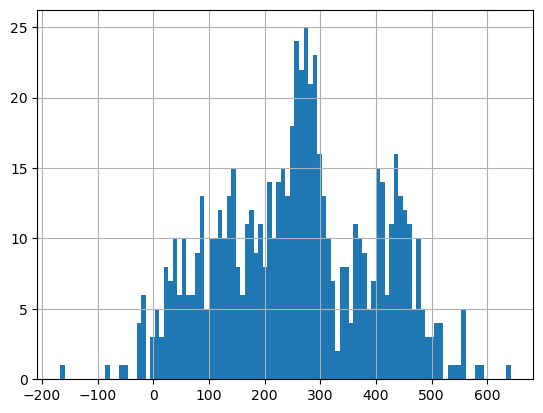

In [26]:
df.shorts_ankle_distance.hist(bins=100)

In [27]:
DRESS_THRESHOLD = 100
df['is_skirt'] = df.shorts_ankle_distance < DRESS_THRESHOLD
df.is_skirt.value_counts()

False    587
True     105
Name: is_skirt, dtype: int64

In [28]:
df_skirts = df[df.is_skirt == True].reset_index(drop=True)
df = df[~df.is_skirt].reset_index(drop=True)

In [29]:
def show_images_df(df, cols, index, cols_per_row=5, save=False, annotate=True, path='full_outs/'):
    # try:
    num_images = len(cols)
    num_rows = (num_images + cols_per_row - 1) // cols_per_row + 1
    fig, axes = plt.subplots(num_rows, cols_per_row, figsize=(20, 4*num_rows))
    t = df.loc[index]
    for i, col in enumerate(cols):
        row = i // cols_per_row
        col_index = i % cols_per_row
        image = t[col]
        if num_rows == 1:
            axes[col_index].set_title(col)
            axes[col_index].imshow(image)
            axes[col_index].axis('off')
        else:
            axes[row, col_index].set_title(col)
            axes[row, col_index].imshow(image)
            axes[row, col_index].axis('off')
    
    if annotate:
        annotation = f'''
        shorts ankle distance: {t.shorts_ankle_distance}
        is skirt: {t.is_skirt}
        no ankles: {t.noankles}
        lowest_y_shorts: {t.lowest_y_shorts}
        highest_y_ankles: {t.highest_y_ankles}
        left_ankles: {t.left_ankles}
        right_ankles: {t.right_ankles}
        '''
        fig.text(0.12, 0.1, annotation, fontsize=24)
        
    # Hide the empty axes
    for i in range(num_images, num_rows*cols_per_row):
        if num_rows == 1:
            axes[i].set_visible(False)
        else:
            row = i // cols_per_row
            col_index = i % cols_per_row
            axes[row, col_index].set_visible(False)

    if save:
        # save as jpg
        plt.savefig(path + df.ids[index] + '.jpg')
        plt.close()
    else:
        plt.show()
    # except Exception as e:
    #     plt.close()
    #     print(e)

In [30]:
tqdm._instances.clear()
images = df['image'].tolist()
images = [copy.deepcopy(arr) for arr in tqdm(images)]
processed_img = [apply_mask(a, b) for a, b in tqdm(zip(images, df['mask_final']))]
df['processed_img'] = processed_img

100%|██████████| 587/587 [00:01<00:00, 550.70it/s]
587it [00:09, 59.33it/s]


In [31]:
tqdm._instances.clear()
images = df_skirts['image'].tolist()
images = [copy.deepcopy(arr) for arr in tqdm(images)]
processed_img = [apply_mask(a, b) for a, b in tqdm(zip(images, df_skirts['mask_shorts']))]
df_skirts['processed_img'] = processed_img

100%|██████████| 105/105 [00:00<00:00, 535.53it/s]
105it [00:01, 74.24it/s]


In [32]:
IMGSIZE

(1024, 768)

In [33]:
tqdm._instances.clear()
images = df_noankles['image'].tolist()

df_noankles['left_ankles_anchors'] = df_noankles.left_ankles_fix.apply(lambda x: (x[0]-ANKLE_DISTANCE_X, IMGSIZE[0]-1))
df_noankles['right_ankles_anchors'] = df_noankles.right_ankles_fix.apply(lambda x: (x[0]+ANKLE_DISTANCE_X, IMGSIZE[0]-1))
df_noankles['mask_left_ankle'] = [mask_from_point(a) for a in df_noankles.left_ankles_anchors]
df_noankles['mask_right_ankle'] = [mask_from_point(a) for a in df_noankles.right_ankles_anchors]
mask_ankle_anchors = Parallel(n_jobs=-1)(delayed(ankle_mask)(a, b, c) for a, b, c in tqdm(zip(df_noankles.image, df_noankles.left_ankles_anchors, df_noankles.right_ankles_anchors)))
df_noankles['mask_ankle_anchors'] = mask_ankle_anchors


df_noankles['mask_shorts_ankles'] = [convex_hull_image(a + b + c) for a, b, c in tqdm(zip(df_noankles.mask_shorts_clean, df_noankles.mask_left_ankle, df_noankles.mask_right_ankle))]



images = [copy.deepcopy(arr) for arr in tqdm(images)]
processed_img = [apply_mask(a, b) for a, b in tqdm(zip(images, df_noankles['mask_shorts_ankles']))]
df_noankles['processed_img'] = processed_img

12it [00:00, 2526.31it/s]
12it [00:01,  9.42it/s]
100%|██████████| 12/12 [00:00<00:00, 763.12it/s]
12it [00:00, 54.07it/s]


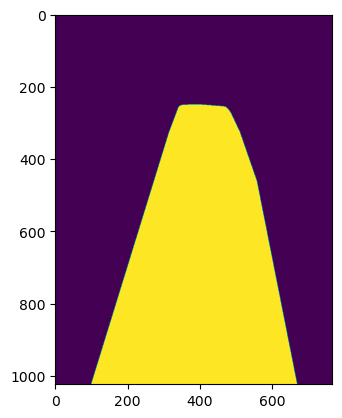

In [34]:
imshow(df_noankles.mask_shorts_ankles[0])

df.columns

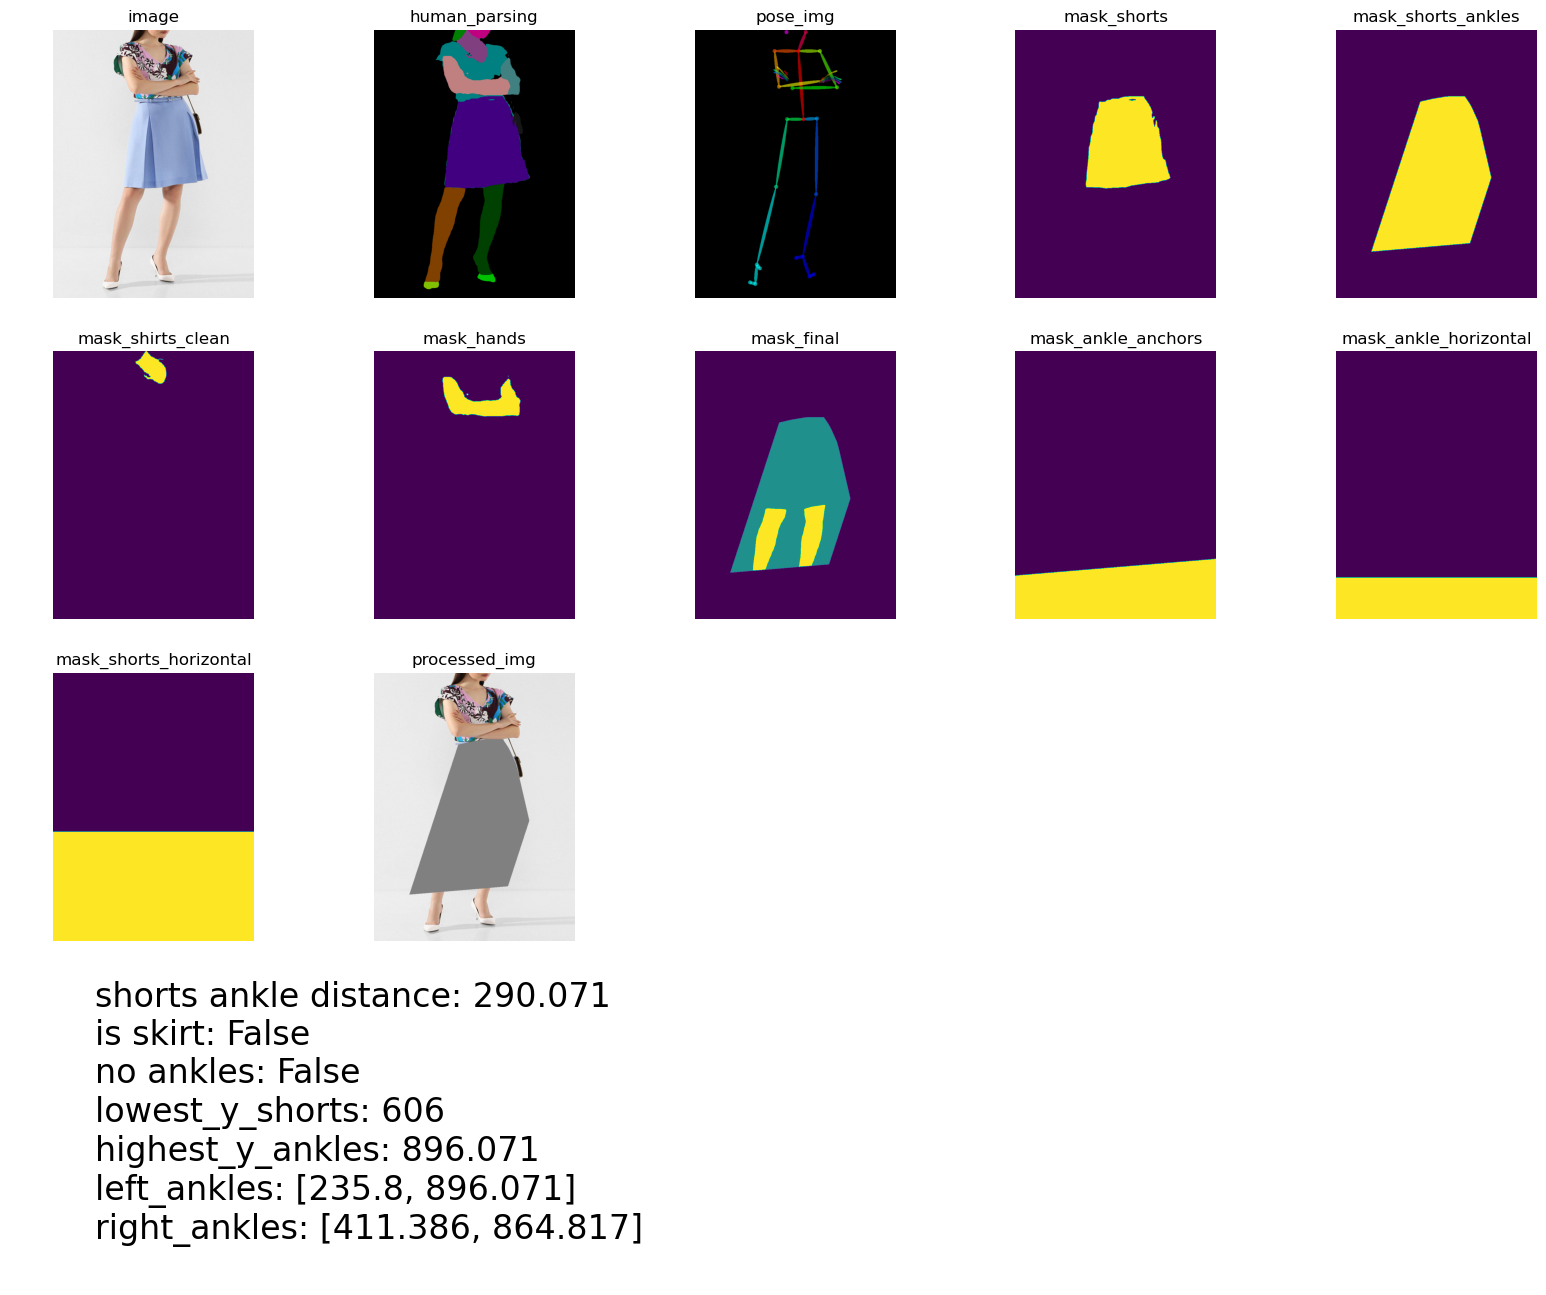

In [35]:
img_cols = [
    'image',
    'human_parsing',
    'pose_img',
    'mask_shorts',
    'mask_shorts_ankles',
    'mask_shirts_clean',
    'mask_hands',
    'mask_final',
    # 'mask_shorts_ankles_legs',
    # 'mask_shirts',
    # 'mask_shorts_clean',
    # 'mask_ankle',
    'mask_ankle_anchors',
    'mask_ankle_horizontal',
    'mask_shorts_horizontal',
    'processed_img'
]
show_images_df(df, img_cols, 0)


In [36]:
len(df), len(df_skirts), len(df_noankles)

(587, 105, 12)

In [37]:
assert(total_len == len(df) + len(df_skirts) + len(df_noankles))

In [38]:
for i in tqdm(range(len(df))):
    show_images_df(df, img_cols, i, path='main_imgs/', save=True)

100%|██████████| 587/587 [16:26<00:00,  1.68s/it]


In [39]:
for i in tqdm(range(len(df_skirts))):
    show_images_df(df_skirts, img_cols, i, path='dress_imgs/', save=True)

100%|██████████| 105/105 [02:41<00:00,  1.54s/it]


In [40]:
for i in tqdm(range(len(df_noankles))):
    show_images_df(df_noankles, img_cols, i, path='noankles/', save=True, annotate=False)

100%|██████████| 12/12 [00:22<00:00,  1.87s/it]


In [52]:
SAVE_PATH = 'C:/code/python/test_task_big/preprocessed_13/'

In [53]:
SAVE_PROCESSED = True
if SAVE_PROCESSED:
    for i, img in tqdm(enumerate(df.processed_img)):
        img.save(SAVE_PATH + df.ids[i] + '.jpg')

587it [00:06, 87.11it/s] 


In [54]:
SAVE_PROCESSED = True
if SAVE_PROCESSED:
    for i, img in tqdm(enumerate(df_skirts.processed_img)):
        img.save(SAVE_PATH + df.ids[i] + '.jpg')

105it [00:01, 101.66it/s]


In [55]:
# add legs convex hull 

In [56]:
SAVE_PROCESSED = True
if SAVE_PROCESSED:
    for i, img in tqdm(enumerate(df_noankles.processed_img)):
        img.save(SAVE_PATH + df.ids[i] + '.jpg')

12it [00:00, 52.08it/s]


In [46]:
# HELPER FUNCTIONS
# def draw_pose(img, poses):
#     draw = ImageDraw.Draw(img)
#     for i in range(0, len(poses), 3):
#         draw.ellipse((poses[i]-5, poses[i+1]-5, poses[i]+5, poses[i+1]+5), fill=(255, 0, 0, 255))
#         draw.text((poses[i], poses[i+1]), str(i//3), fill=(255, 0, 0, 0), font= ImageFont.truetype("arial.ttf", 30))
#     return img
# draw_pose(df.image[0], df.pose_keypoints[0])

In [47]:
# def line_intersection(line1, line2):
#     xdiff = (line1[0][0] - line1[1][0], line2[0][0] - line2[1][0])
#     ydiff = (line1[0][1] - line1[1][1], line2[0][1] - line2[1][1])

#     def det(a, b):
#         return a[0] * b[1] - a[1] * b[0]

#     div = det(xdiff, ydiff)
#     if div == 0:
#        raise Exception('lines do not intersect')

#     d = (det(*line1), det(*line2))
#     x = det(d, xdiff) / div
#     y = det(d, ydiff) / div
#     return x, y

# def order_points(pts):
#     # initialzie a list of coordinates that will be ordered
#     # such that the first entry in the list is the top-left,
#     # the second entry is the top-right, the third is the
#     # bottom-right, and the fourth is the bottom-left
#     rect = np.zeros((4, 2), dtype = "float32")

#     # the top-left point will have the smallest sum, whereas
#     # the bottom-right point will have the largest sum
#     s = pts.sum(axis = 1)
#     rect[0] = pts[np.argmin(s)]
#     rect[2] = pts[np.argmax(s)]

#     # now, compute the difference between the points, the
#     # top-right point will have the smallest difference,
#     # whereas the bottom-left will have the largest difference
#     diff = np.diff(pts, axis = 1)
#     rect[1] = pts[np.argmin(diff)]
#     rect[3] = pts[np.argmax(diff)]

#     # return the ordered coordinates
#     return rect

# def get_box(mask):
#     mask = convex_hull_image(clean_outliers(mask))
#     box = cv2.goodFeaturesToTrack(
#         mask.astype(np.uint8), 
#         maxCorners=4, 
#         minDistance=20, 
#         blockSize=20,
#         qualityLevel=0.001)
#     box = np.array([a[0] for a in box])
#     box = order_points(box)
#     box = np.int0(box)
#     return box
#     # top_left, top_right, bottom_right, bottom_left = box

# def prolong_shorts(shorts, left_ankle, right_ankle):
#     try:
#         top_left, top_right, bottom_right, bottom_left = get_box(shorts)
#         ankle_line = ((left_ankle[0], left_ankle[1]), (right_ankle[0], right_ankle[1]))
#         left_line = ((top_left[0], top_left[1]), (bottom_left[0], bottom_left[1]))
#         left_intersection = line_intersection(left_line, ankle_line)
#         right_line = ((top_right[0], top_right[1]), (bottom_right[0], bottom_right[1]))
#         right_intersection = line_intersection(right_line, ankle_line)
#         mask = Image.fromarray(np.zeros(shorts.shape, dtype=np.uint8))
#         draw = ImageDraw.Draw(mask)
#         draw.polygon([tuple(top_left), tuple(left_intersection), tuple(right_intersection), tuple(top_right)], outline=1, fill=1)
#         mask = np.array(mask)
#         mask = mask
#         return mask
#     except Exception as e:
#         print(e)
#         return None

# # N = 36
# # imshow(prolong_shorts(df.mask_shorts[N], df.left_ankles[N], df.right_ankles[N]))

# # tqdm._instances.clear()
# # boxes_shorts = Parallel(n_jobs=-1)(
# #     delayed(get_box)(a) for a in tqdm(df.mask_shorts)
# # )
# # df['boxes_shorts'] = boxes_shorts

# # tqdm._instances.clear()
# # mask_prolonged_shorts = Parallel(n_jobs=14)(
# #     delayed(prolong_shorts)(a, b, c) for a, b, c in tqdm(zip(df.mask_shorts, df.left_ankles, df.right_ankles))
# # )
# # df['mask_prolonged_shorts'] = mask_prolonged_shorts